In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import dl_codebase.main.__init_lib_path
from config_guard import cfg, update_config_from_yaml
import dataset
import network
import classifier
import loss

desired_config_file = "./dl_codebase/configs/cvae_planning/narrow_world_naive_vae.yaml"
weight_path = "./dl_codebase/cvae_motion_planning_narrow_with_naive_vae_final.pt"

In [3]:
import sys
import os

def add_path(custom_path):
    if custom_path not in sys.path: sys.path.insert(0, custom_path)

this_dir = os.getcwd()
# [1] Path to modules
lib_path = os.path.join(this_dir, 'planning_scenario', 'geometric')
add_path(lib_path)

In [4]:
class temp:
    def __init__(self):
        self.cfg = desired_config_file
pseudo_args = temp()
update_config_from_yaml(cfg, pseudo_args)

use_cuda = not cfg.SYSTEM.use_cpu
device = torch.device("cuda" if use_cuda else "cpu")

train_set, test_set = dataset.dispatcher(cfg)

Net = network.dispatcher(cfg)
model = Net(cfg).to(device)
model.load_state_dict(torch.load(weight_path))
model.eval()

net(
  (linear1): Linear(in_features=18, out_features=512, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (relu2): ReLU()
  (linear3_mu): Linear(in_features=512, out_features=3, bias=True)
  (linear3_log_var): Linear(in_features=512, out_features=3, bias=True)
  (inv_linear3): Linear(in_features=19, out_features=512, bias=True)
  (inv_relu2): ReLU()
  (inv_linear2): Linear(in_features=512, out_features=512, bias=True)
  (inv_relu1): ReLU()
  (inv_linear1): Linear(in_features=512, out_features=2, bias=True)
)

In [5]:
def cool_forward(x, label = None):
    return model.decode(x, label)

In [6]:
from planning_scenario.geometric.narrow_world import narrow_world

## Attempt on training set to make sure it's working

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


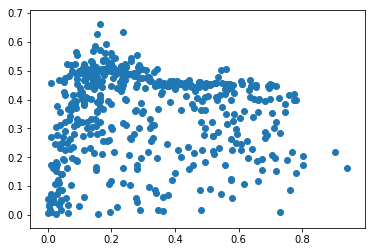

In [7]:
x, cond = train_set[5]
x = torch.tensor(x, device = device)
cond = torch.tensor(cond, device = device)
#x = x.view((1, -1))
cond = cond.view((1, -1))
#print(x)
#print(res)
sample_cnt = 500
# get conditional
cond = torch.cat([cond for i in range(sample_cnt)], dim = 0)
# generate random points
a = np.random.normal(size = (sample_cnt, 3))
a = torch.tensor(a, dtype = torch.float, device = device)
# Pad and compute!
res = cool_forward(a, cond)
res.shape
#res = res.reshape((28, 28)).detach().cpu().numpy()
#plt.imshow(res)
prompted_points = res.detach().cpu().numpy()
plt.figure()
plt.scatter(prompted_points[:,0], prompted_points[:,1])
plt.show()

## Try to solve a new problem

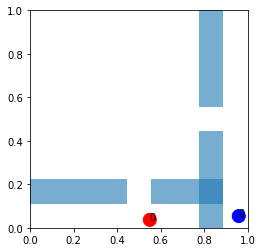

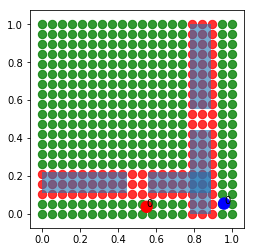

In [8]:
test_world = narrow_world(1)
test_world.plot(draw_ogrid = False)
test_world.plot(draw_ogrid = True)

In [9]:
sample_cnt = 600
# get conditional
cond = test_world.get_trainable_data(best_soln = [0, 0])
cond = cond[0][1]
cond = torch.tensor(cond, dtype = torch.float, device = device).view((1, -1))
cond = torch.cat([cond for i in range(sample_cnt)], dim = 0)
# generate random points
a = np.random.normal(size = (sample_cnt, 3))
a = torch.tensor(a, dtype = torch.float, device = device)
# Pad and compute!
res = cool_forward(a, cond)
res.shape
#res = res.reshape((28, 28)).detach().cpu().numpy()
#plt.imshow(res)

torch.Size([600, 2])

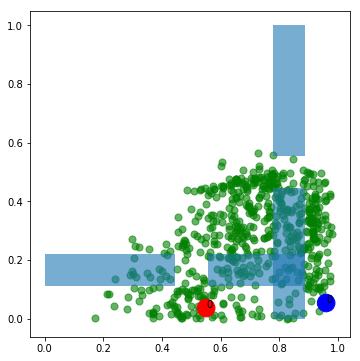

In [10]:
# plot scatter
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, aspect = 'equal')
prompted_points = res.detach().cpu().numpy()
test_world.plot(ax = ax, draw_ogrid = False)
ax.scatter(prompted_points[:,0], prompted_points[:,1], color = "green", alpha = 0.6, s= 50)
plt.show()